# TrackML scoring function



<br>

In the context of tracks reconstruction, a cost function is needed to evaluate potential solutions. The cost function defined below is at track level. Given any track solution ie a list of hits id, we retreive the corresponding truth track and meseaure dissimilarities of the following order:
        - Number and position of missed hits
        - Fake hits
        - (next version) Physics properties of tracks : transverse momentum..etc

##### Exclusive hits labeling is imposed
        
In this notebook, various functions are defined to load and parse the data, retreive truth tracks, score solutions and finally the scoring is evaluated on random solutions and on an ML reco algorithm.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sea
from scipy import interpolate
from random import randint
import ast
import random
from sklearn.cluster import AgglomerativeClustering
from itertools import cycle

#visualization funcs
import sys; sys.path.append('../')
from trackml.utils import plot_tracks,proposal2weight,plot_colored_tracks,sortAlongZ
from trackml.utils import data2tracks,read_Hits,get_hits_id,fetch_truth_ID
from sklearn import metrics
sea.set_style("whitegrid")
#path to data
hitsFilename="../example/event000000001-hits.csv"
truthFilename="../example/event000000001-truth.csv"
particlesFilename="../example/event000000001-particles.csv"
path2data='../example/'
prefix='event000000001'


## Reconstructed track cost 

- Purity of track 
- Ratio of fake hits added 
- Cost of missed hits according to weight proposal

In [3]:
def track2cost(Reco_track,truth_track,W_proposal=[10,8,6,5,3,3,3,5,6],W_over_hits=10,allow_neg=True):
    """
    Reco_track: Recognized track given by clustering techniques

    truth track : the true track

    W_proposal : A weight proposal for each point along the track/curve

    W_over_hits : A weight proposal for appending fake points to the track

    """
    #ratio missed hits
    intersection = [item for item in Reco_track for t in truth_track if (item == t)]
    Purity= len(intersection)/float(len(truth_track))
    if Purity>0.5:
        #weight_missed_hits
        cost=0
        first_hits_lost=0
        intersection=[i for i in intersection]   
        #find position of missed hits
        missed_hits= [hit for hit in truth_track if hit not in intersection]
        #Compute cost        
        for m in np.array(missed_hits):
            pos_missed=np.where(truth_track==m)[0][0]
            if pos_missed in [0,1,2]:
                first_hits_lost+=1
            if len(truth_track)==len(W_proposal):
                cost+=W_proposal[pos_missed]
            else:
                W_proposal=proposal2weight(len_track=len(truth_track))
                cost+=W_proposal[pos_missed]
        over_ratio=len(Reco_track)/float(len(truth_track))
        over_ratio=W_over_hits*over_ratio
        track_score=1-(cost+over_ratio)/float(sum(W_proposal))
        if not allow_neg:
            if track_score<0:
                track_score=0
        else:
            if track_score<=-1:
                track_score=-1
        return track_score
    else:

        return 0

A perfect track would be rated 1 
$$ Score = 1- \frac{hitsCost+ overHitRatio}{TrackWeight} $$


Where given 

$$R=\frac{length_{reco}}{length_{truth}}$$ 

We have: 

$$ overHitRatio = 10 * (R-1 )$$  
#### if R>=1 and overHitRatio=0 otherwise



## Validating the cost function on randomly reconstructed tracks

We randomly modify truch tracks to simulate reconstruction scenario as follow:

 -  Remove one of three first hits
 -  Remove one, two or three hits
 -  Adds one, two or three hits

In [4]:
def rand_reco(truth_track,rand_op=0,qte=1):
    #remove one of first 3
    if rand_op==0 :
        hit=qte#randint(0,2)
        return truth_track[:hit] + truth_track[hit+1 :]       
    #remove two three or four hits    
    if rand_op==1 :
        if len(truth_track)>3:
            for i in range(qte):
              
                r=random.randrange(len(truth_track))
                truth_track= truth_track[:r] + truth_track[r+1 :]
            return truth_track
    #adds randomly hits to truth track
    if rand_op==2 : 
        for i in range(qte):
            truth_track=np.insert(truth_track,-1,randint(0,100))
        return list(truth_track)
    #remove one of first 3 and adds randomly hits to truth track
    if rand_op==3:
        truth_track=np.array(truth_track[:qte] + truth_track[qte+1 :])
        for i in range(qte):
            truth_track=np.insert(truth_track,-1,randint(0,100))
        return list(truth_track)
    return truth_track

In [5]:
def get_sorted_idx(idx,Hits):
    xyz=Hits.ix[idx,["x","y","z"]].values
    Z=[i[2] for i in xyz]
    sorted_idx_idx=[i[0] for i in sorted(enumerate(Z), key=lambda x:x[1])]
    sorted_idx = [idx[i] for i in sorted_idx_idx]
    return sorted_idx

### Solution degradation analysis
- removing one of 3 first hits (here we remove always 2nd hit)
- randomly removing a single hit (no position constraints)
- randomly adding a hit 
- removing one of 3 first hits + randomly adding a hit  (same lengh track but with fake)

score (first rmv): 0.9
score (rand rmv): 0.944
score (rand add): 0.966
score (1+3): 0.873


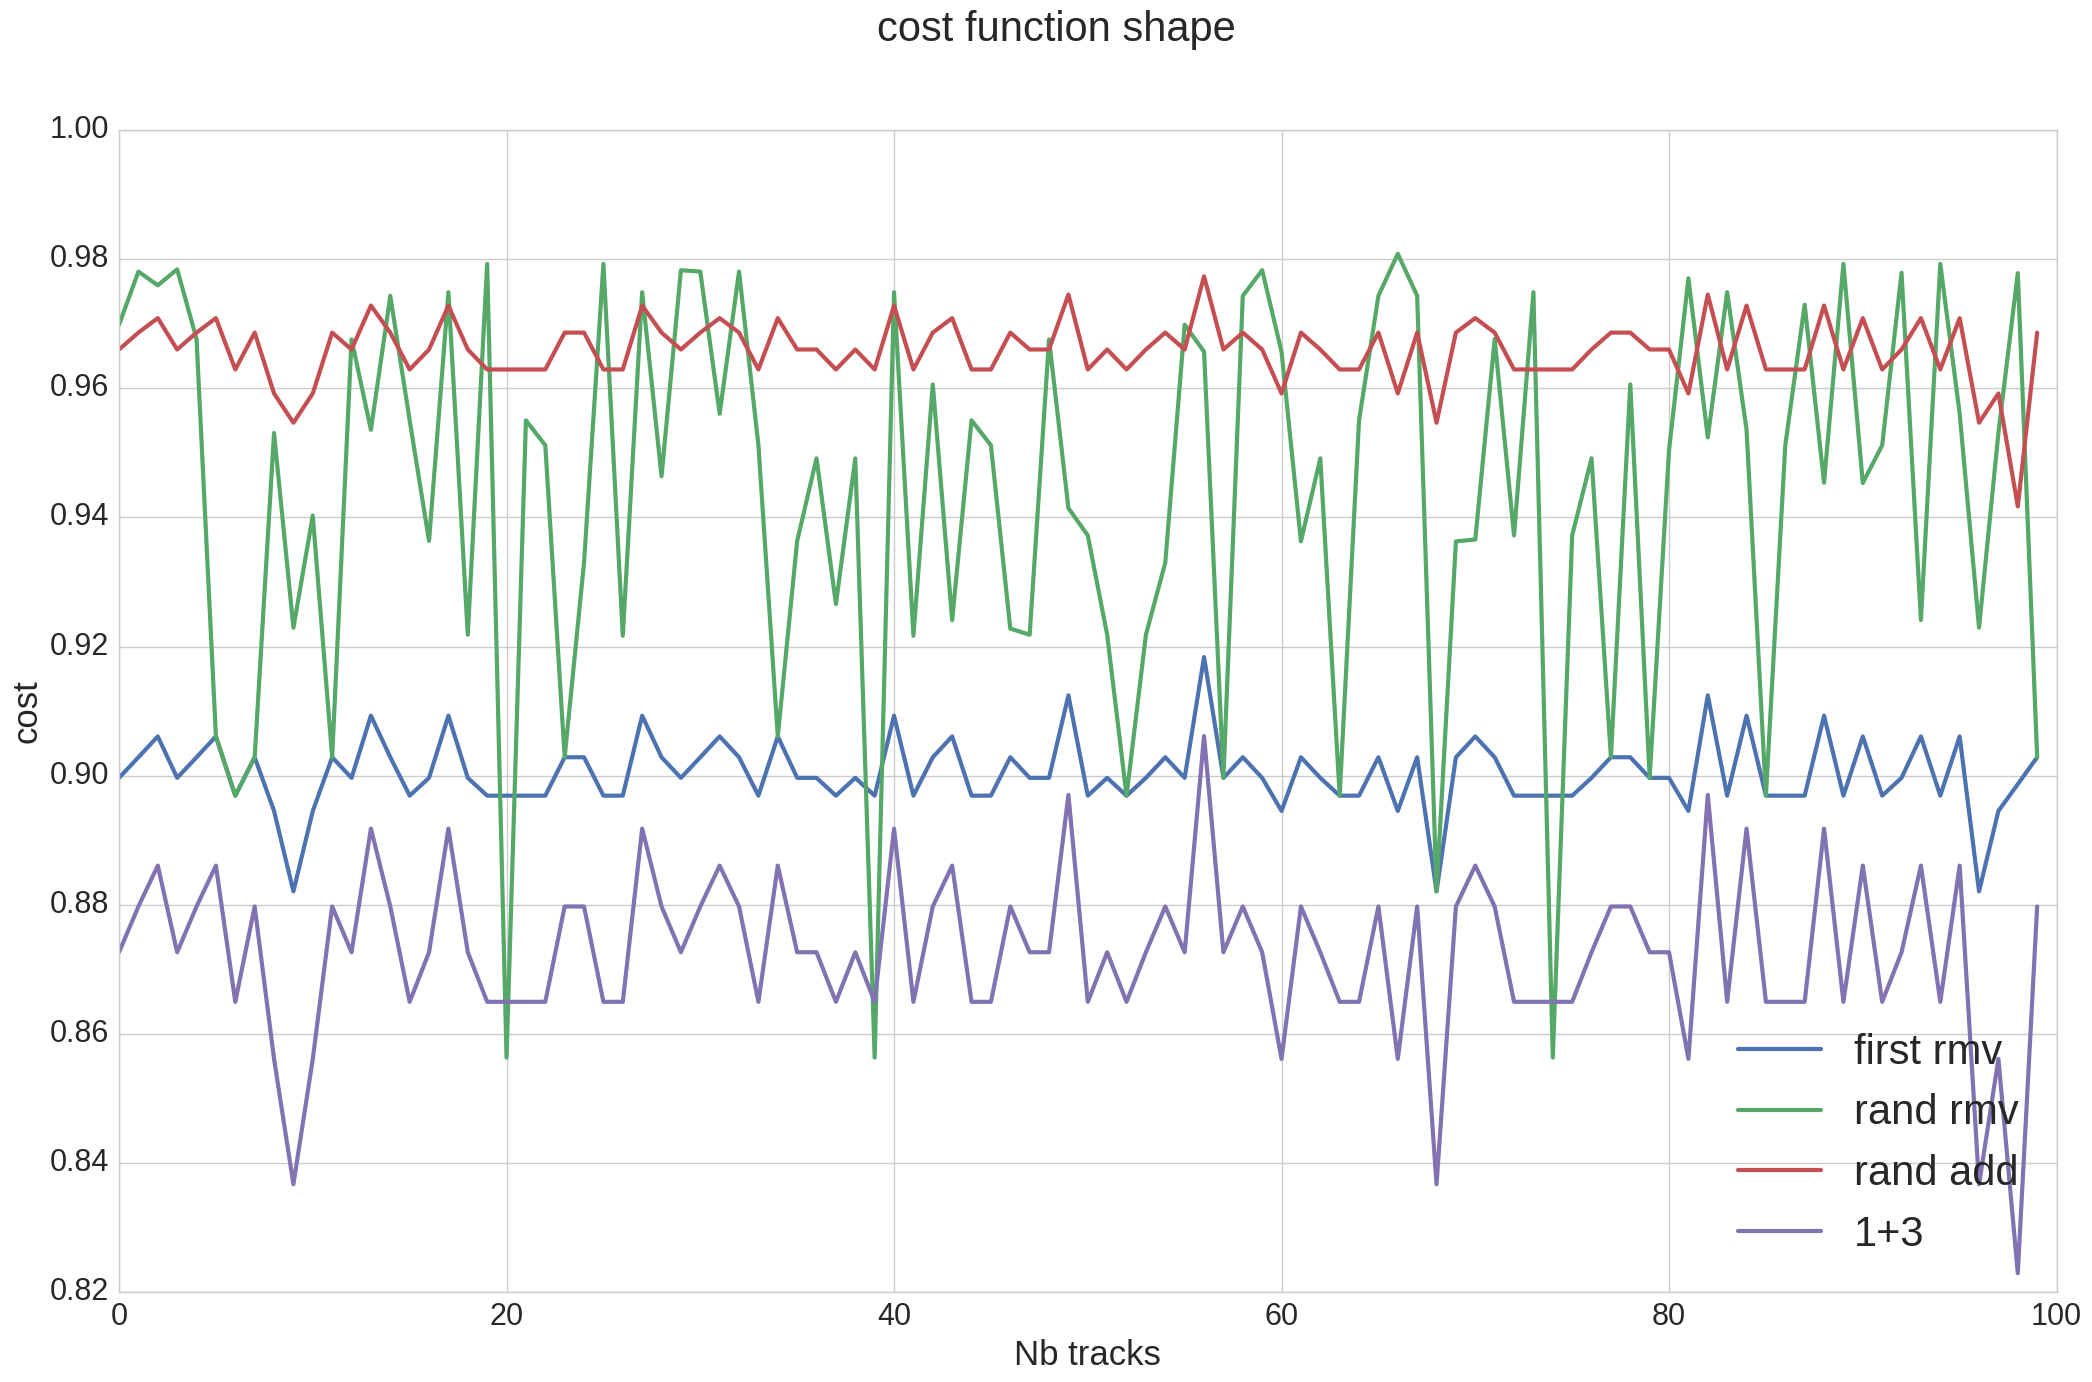

In [6]:
tracks,Hits=data2tracks(prefix,path2data)
#control number of hits to change ( and position of hit to remove)
qte=1
fig = plt.figure(figsize=(25,15))
fig.suptitle('cost function shape', fontsize=30)
plt.xlabel('Nb tracks', fontsize=25)
plt.ylabel('cost', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=22)
labels_op=["first rmv","rand rmv","rand add","1+3"]
for rand_op in [0,1,2,3]: 
    score=0
    event_score=[]
    for t in tracks:
        t=get_sorted_idx(t,Hits)
        reco=rand_reco(t,rand_op=rand_op,qte=qte)
        cost=track2cost(reco,t)
        event_score.append(cost)
        score+=cost
    plt.plot(event_score,"-",linewidth=3,label=labels_op[rand_op])
    print ("score ("+str(labels_op[rand_op])+"): "+str(round(score/ len(tracks),3)))
plt.legend(fontsize=30,loc="lower right")
plt.show()

## Validating the cost function on ML reco tracks

In [7]:
from scipy.cluster.hierarchy import  linkage, fcluster
def cluster_hits2tracks(testX,max_d=0.0005,affinity="cosine"):
    """
    Simple PoC reconstruction algorithm
    """
    Z = linkage(testX, 'complete',metric=affinity)
    clusters = fcluster(Z, max_d, criterion='distance')
    return clusters

In [8]:
hits=read_Hits(hitsFilename)
truth=pd.read_csv(truthFilename)
particles=pd.read_csv(particlesFilename)
#add pT column
def getpT(row):
    return np.sqrt(row['px']**2+row['py']**2+row['pz']**2)
particles['pt'] = particles.apply(getpT, axis=1)

df_data=pd.merge(truth, hits, on =['hit_id']).ix[:,["hit_id","particle_id","x","y","z"]]
df_data=df_data.ix[:,["hit_id","particle_id","x","y","z"]]

In [9]:
"""
unsupervised clustering of hits
"""
Nb_particle=100
selected_part=np.unique(df_data.particle_id)[:Nb_particle]#particles.loc[particles.pt>100].particle_id
idx_particle=df_data.loc[df_data.particle_id.isin(selected_part)].index
xyz=list(df_data.ix[idx_particle,["x","y","z"]].values)
solution=cluster_hits2tracks(xyz)

In [10]:
#simple position by position score
print ("simple score: ",round(metrics.adjusted_rand_score(solution,df_data.particle_id.values[idx_particle]),3))

('simple score: ', 0.645)


## 3D score

In [11]:
"""
computing 3D score for each track
"""
def score_3d(solution,allow_neg=True):
    score=[]
    for i in np.unique(solution):
        idx=np.where(solution==i)[0]
        #getting corresponding truth (>0.5 purity)
        truth_idx=fetch_truth_ID(idx,df_data)
        if truth_idx is not None:
            sc=round(track2cost(df_data.ix[idx].hit_id,df_data.ix[truth_idx].hit_id,allow_neg=allow_neg),2)
        else:
            sc=0
        score.append(sc)
    return score

In [12]:
#3D score  - good solution
score=np.array(score_3d(solution))
print ("mean score -1,1 :  ",round(np.mean(score),3))
idxRetrieved=np.where(score>0)[0]
print ("mean effeciency (from retreived tracks) :  ",round(np.mean(score[idxRetrieved]),3))

('mean score -1,1 :  ', 0.142)
('mean effeciency (from retreived tracks) :  ', 0.809)


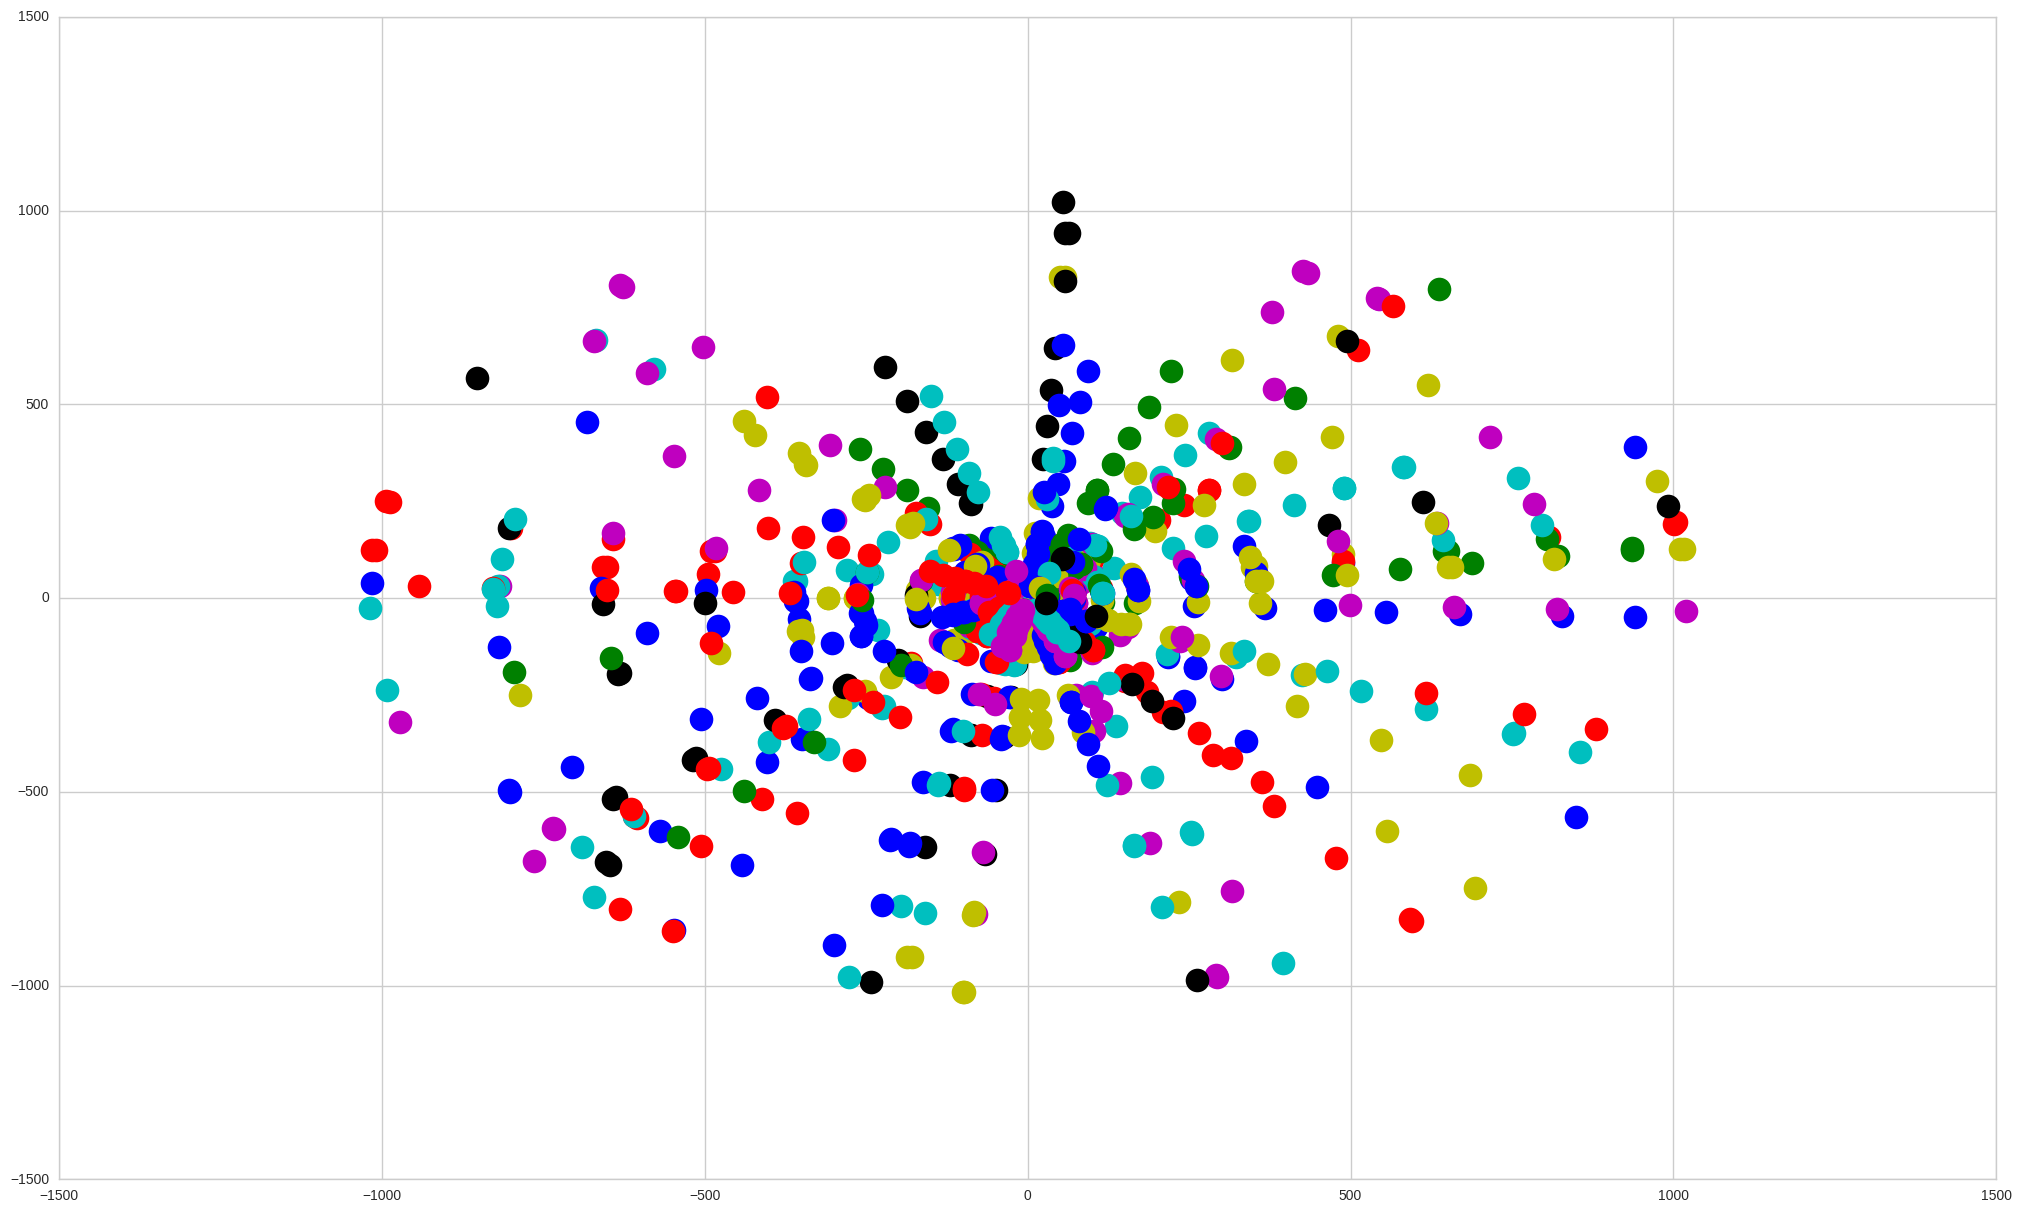

In [13]:
#plots
fig = plt.figure(figsize=(25,15))
fig.suptitle('cost function shape', fontsize=30)
plt.xlabel('Nb tracks', fontsize=25)
plt.ylabel('cost', fontsize=25)
plt.plot(score,"-o")
plt.tick_params(axis='both', which='major', labelsize=22)

plt.show()

plot_colored_tracks(solution,xyz)

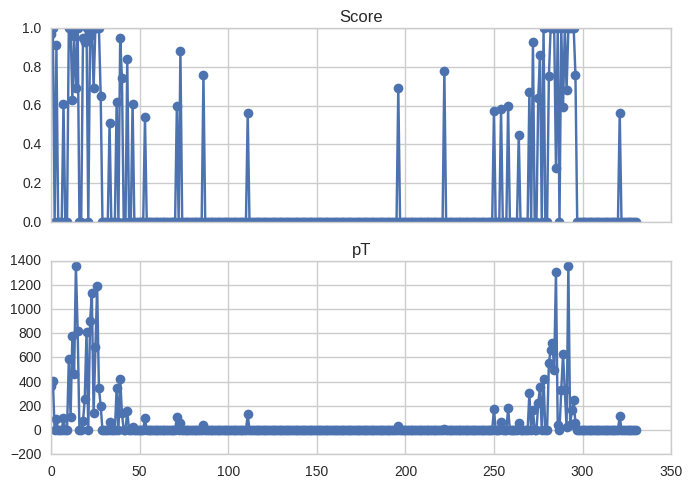

In [14]:
pts=[]
score=[]
for i in np.unique(solution):
    idx=np.where(solution==i)[0]
    truth_idx=fetch_truth_ID(idx,df_data)
    if truth_idx is not None:
        sc=round(track2cost(df_data.ix[idx].hit_id,df_data.ix[truth_idx].hit_id),2)
        curr_id=df_data.ix[truth_idx,["particle_id"]].values[0][0]
        curr_pt=particles.loc[particles.particle_id==curr_id].pt.values[0]
        score.append(sc)
        pts.append(curr_pt)
    else:
        pts.append(-1)
        score.append(0)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(score,"-o")
axarr[0].set_title('Score')
axarr[1].plot(pts,"-o")
axarr[1].set_title('pT')

plt.show()

/home/grey-sab/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


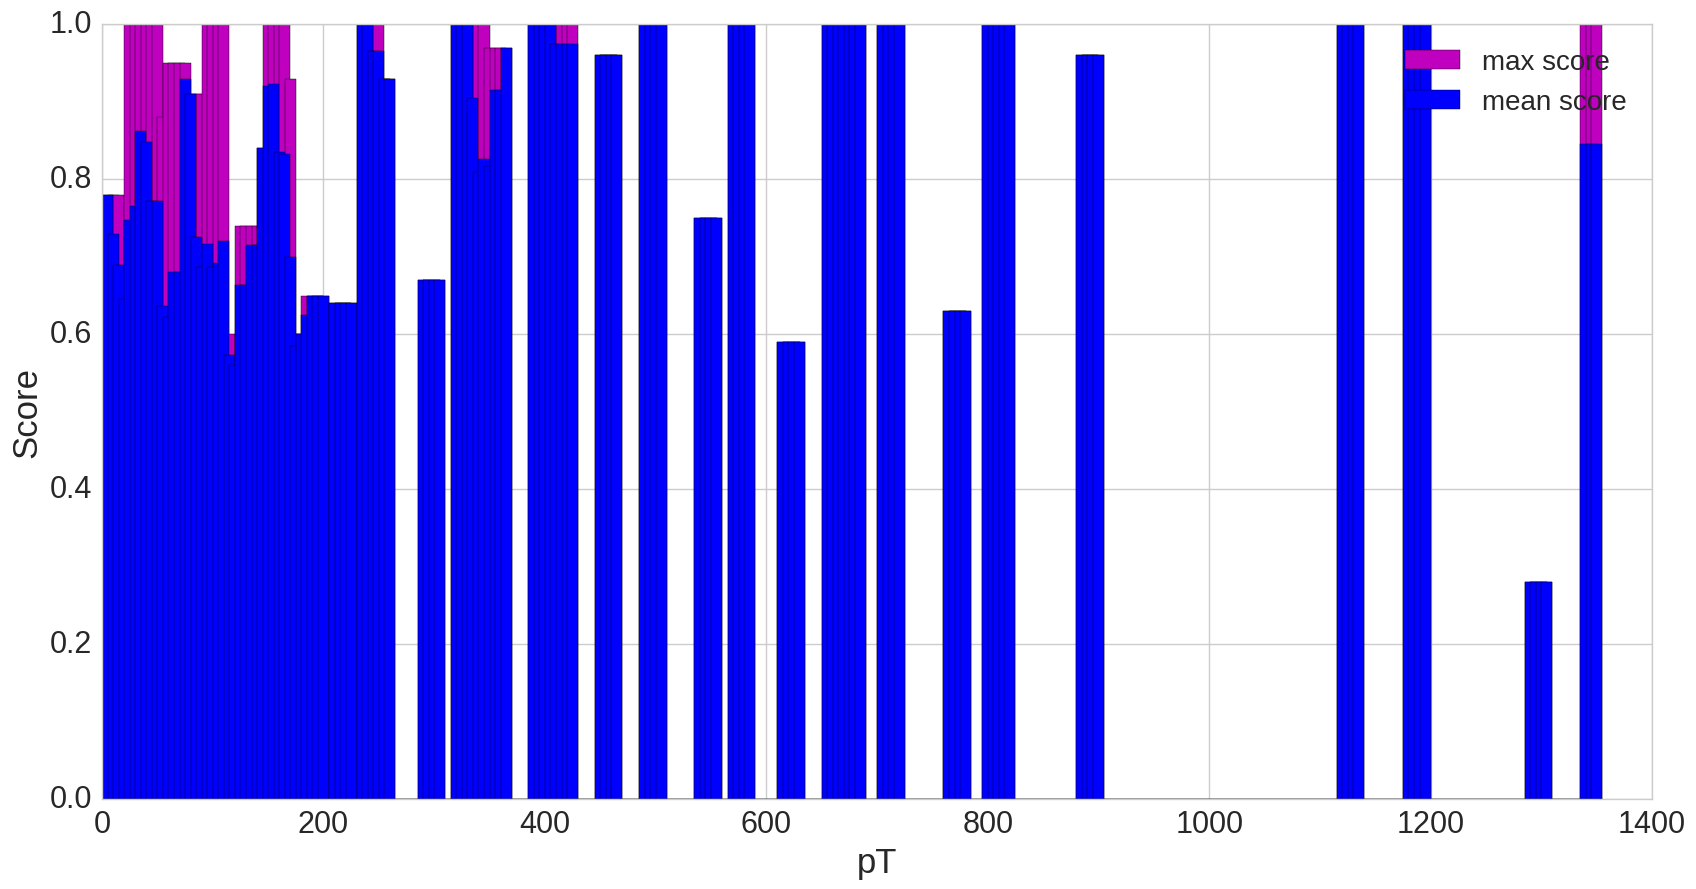

In [20]:
pt_ana=pd.DataFrame(np.column_stack((score,pts)))
pt_ana.columns=["score","pt"]
scorePerRange=[]
std_range=[]
for i in range(0,int(np.max(pt_ana.pt.values))-5,5):
    scorePerRange.append(np.mean(pt_ana.loc[(i<pt_ana.pt) & (pt_ana.pt<i+20)].score.values))
    if len(pt_ana.loc[(i<pt_ana.pt) & (pt_ana.pt<i+20)].score.values)>0:
        std_range.append(np.max(pt_ana.loc[(i<pt_ana.pt) & (pt_ana.pt<i+20)].score.values))
    else:
        std_range.append(0)
fig = plt.figure(figsize=(20,10))
plt.bar(range(0,int(np.max(pt_ana.pt.values))-5,5),std_range,width=10,color="m",label="max score")
plt.bar(range(0,int(np.max(pt_ana.pt.values))-5,5),scorePerRange,width=10,color="b",label="mean score")
plt.xlabel("pT",fontsize=25)
plt.ylabel("Score",fontsize=25)
plt.legend(loc="upper right",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()